In [1]:
import numpy as np

from models import ExampleModel
from methods import TrackingADMM, DPMM, APAPC, Main
from utils import save_object, load_object

from matplotlib import pyplot as plt

myparams = {
    #'text.usetex': True,
    #'text.latex.preamble': r'\usepackage{amsfonts}',
    #'font.family': 'Djvu Serif',
    'font.size': 16,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'lines.linewidth': 2
}

plt.rcParams.update(myparams)

%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

# Numerical Experiment

There we will use a model from Example 2 in paper ["Decentralized Proximal Method of Multipliers for Convex Optimization with Coupled Constraints", 2023](https://arxiv.org/pdf/2310.15596.pdf), but with L2 borm instead of L1, universal regularization parameter for all nodes, without right part of equality constraints and without inequality constraints.

This problem is also similar to Example in paper ["Decentralized Strongly-Convex Optimization with Affine Constraints: Primal and Dual Approaches"](https://arxiv.org/pdf/2207.04555.pdf), but there are distinct variables on each node.

$$ \min_{\mathbf{x}} F(\mathbf{x}) = \sum\limits_{i=1}^{n} \Big( \frac{1}{2}\| C_i x_i - d_i \|_2^{2} + \frac{\theta}{2} \| x_i \|_2^2 \Big) $$
$$ \textrm{s.t.} \quad \sum\limits_{i=1}^{n} \left( A_i x_i - b_i \right) = 0 $$ 
We can calculate function, gradient and hessian using
$$ \mathbf{C} = \mathrm{diag}\left(C_1, \ldots, C_n \right), \quad \mathbf{d} = \mathrm{col}\left( d_1, \ldots, d_n \right) $$
as
$$ F(\mathbf{x}) = \frac{1}{2}\| \mathbf{C} \mathbf{x} - \mathbf{d} \|_2^{2} + \frac{\theta}{2} \| \mathbf{x} \|_2^2 $$
$$ \nabla F(\mathbf{x}) = \mathbf{C}^\top \mathbf{C} \mathbf{x} - \mathbf{C}^\top \mathbf{d} + \theta \mathbf{x} $$
$$ \nabla^2 F(\mathbf{x}) = \mathbf{C}^\top \mathbf{C} + \theta I_{d} $$

In [7]:
np.random.seed(307)

NUM_STEPS = 10_000
#NUM_STEPS = 100
n = 50
m = 10
d = 20
#graph = 'ring'
graph = 'erdos-renyi'
average_degree = 5

model = ExampleModel(n, m, d, graph, edge_prob=average_degree/n, gossip=False)
#model = ExampleModel(n, m, d, graph, gossip=False)

Elapsed time adjacency_matrix: 0.00 seconds


In [6]:
titles = ['Tracking-ADMM', 'DPMM', 'Main']
results = {title: {} for title in titles}

#output = TrackingADMM(num_steps=NUM_STEPS, model=model)
#output = TrackingADMM(num_steps=10 * NUM_STEPS, model=model)
#results['Tracking-ADMM'] = output

#output = DPMM(num_steps=NUM_STEPS, model=model)
output = DPMM(num_steps=100 * NUM_STEPS, model=model)
results['DPMM'] = output

output = Main(num_steps=NUM_STEPS, model=model)
results['Main'] = output

  0%|          | 8/1000000 [00:01<62:12:40,  4.47it/s]


KeyboardInterrupt: 

KeyError: 'grad_calls'

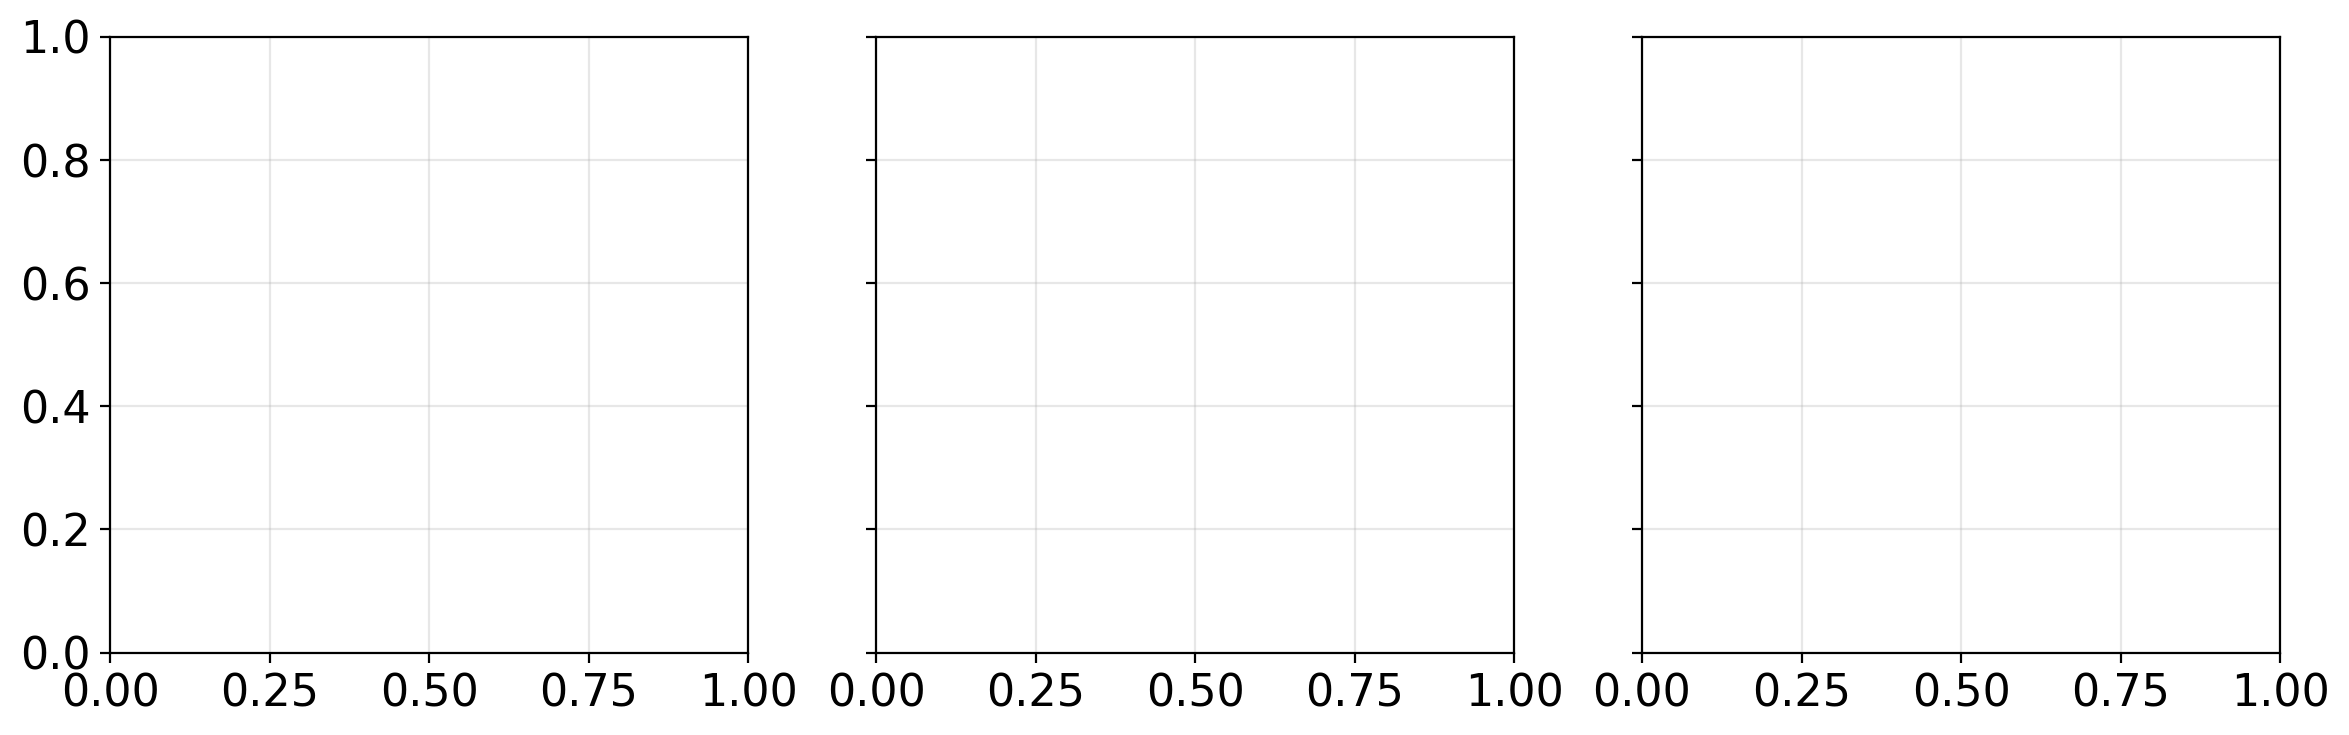

In [5]:
filename = f'{graph}_n-{model.n}_d-{model.d}_m-{model.m}'
filename_fig = 'figs/example/' + filename + '.pdf'
filename_dump = 'dumps/example/' + filename + '.pkl'

#results = load_object(filename_dump)

fig, ax = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

for title in results.keys():
    output = results[title]
    x_vals = np.cumsum(output['grad_calls'])
    y_vals = output['x_err']
    if title == 'Main':
        title = 'Main algorithm'
    ax[0].plot(x_vals, y_vals, label=title)
ax[0].legend(loc='upper right')
ax[0].yaxis.set_tick_params(labelleft=True)
ax[0].set_xlim(left=0, right=10_000)
ax[0].set_ylim(bottom=1e-21, top=1e3)
ax[0].set_yscale('log')
ax[0].set_xlabel("Gradient calls")
ax[0].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

for title in results.keys():
    output = results[title]
    x_vals = np.cumsum(output['mults_A'])
    y_vals = output['x_err']
    if title == 'Main':
        title = 'Main algorithm'
    ax[1].plot(x_vals, y_vals, label=title)
ax[1].legend(loc='upper right')
ax[1].yaxis.set_tick_params(labelleft=True)
ax[1].set_xlim(left=0, right=400_000)
ax[1].set_yscale('log')
ax[1].set_xlabel("Mult. by $\mathbf{A}$ and $\mathbf{A}^T$")
ax[1].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

for title in results.keys():
    output = results[title]
    x_vals = np.cumsum(output['communications'])
    y_vals = output['x_err']
    if title == 'Main':
        title = 'Main algorithm'
    ax[2].plot(x_vals, y_vals, label=title)
ax[2].legend(loc='upper right')
ax[2].yaxis.set_tick_params(labelleft=True)
ax[2].set_xlim(left=0, right=400_000)
ax[2].set_yscale('log')
ax[2].set_xlabel("Communications")
ax[2].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

#plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
fig.text(0, 0.5, r"$\| x^k - x^* \|_2^2$", va='center', rotation='vertical')
graph_name = 'Ring' if graph == 'ring' else 'Erdős–Rényi'
#plt.suptitle(f'{graph_name}, $n = {model.n}$, $d_i = {model.d}$, $m = {model.m}$', fontsize=24)
plt.tight_layout()
plt.savefig(filename_fig, bbox_inches='tight')
save_object(results, filename_dump)
plt.show()